In [22]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

from adaptms.AdaptmsClassifier import AdaptmsClassifierFolder
from adaptms.BaselineClassifier import BaselineClassifier
from adaptms.NonRefitClassifier import NonRefitClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Adjust matplotlib settings for font inclusion
plt.rcParams['pdf.fonttype'] = 42  # Use Type 3 (PostScript) fonts
plt.rcParams['ps.fonttype'] = 42

# Set filpaths for data and figures
notebook_dir = os.getcwd()
file_path = Path(notebook_dir).parent / 'data' 

# Load Data

In [24]:
df = pd.read_csv(file_path / "AD_CSF_Sweden.pg_matrix.tsv", sep='\t')
gene_dict = dict(zip(df['Protein.Group'], df['Genes']))
prot = df.set_index('Protein.Group').iloc[:,4:].T
prot.index = [a.split('/')[-1] for a in prot.index]
prot.index = [a.split('.')[0] for a in prot.index]
prot = np.log10(prot.replace(0, np.nan))

In [25]:
d_Mag = pd.read_csv(file_path / 'AD_CSF_MagKiel.pg_matrix.tsv', sep='\t')
d_Mag_prot = d_Mag.set_index('Protein.Group').iloc[:,4:].T
d_Mag_prot.index = [a.split('/')[-1] for a in d_Mag_prot.index]
d_Mag_prot.index = [a.split('.')[0] for a in d_Mag_prot.index]
d_Mag_prot = np.log10(d_Mag_prot.replace(0, np.nan))

In [26]:
d_Berlin = pd.read_csv(file_path / 'AD_CSF_Berlin.pg_matrix.tsv', sep='\t')
d_Berlin_prot = d_Berlin.set_index('Protein.Group').iloc[:,4:].T
d_Berlin_prot.index = [a.split('/')[-1] for a in d_Berlin_prot.index]
d_Berlin_prot.index = [a.split('.')[0] for a in d_Berlin_prot.index]
d_Berlin_prot = np.log10(d_Berlin_prot.replace(0, np.nan))

In [27]:
d_groups = pd.read_excel(file_path / "annotation of samples_AM1.5.11.xlsx")
d_groups = d_groups.dropna(subset='sample name')
cat = d_groups.set_index('sample name')[['biochemical AD classification']]
cat.index = [a.split('.')[0] for a in cat.index]

# xgboost with holdout_batch testset and scambled labels

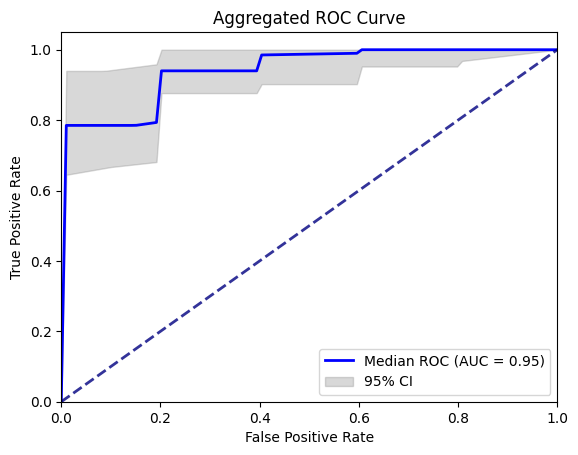

In [28]:
# Initialize the classifier
baseline = BaselineClassifier(prot, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
baseline.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, n_estimators=100)

# MAG cohort

In [29]:
# Find shared columns
shared_columns = prot.columns.intersection(d_Mag_prot.columns)

# Keep only shared columns in both DataFrames
prot_shared = prot[shared_columns]
d_Mag_prot_shared = d_Mag_prot[shared_columns]

# Baseline classifier

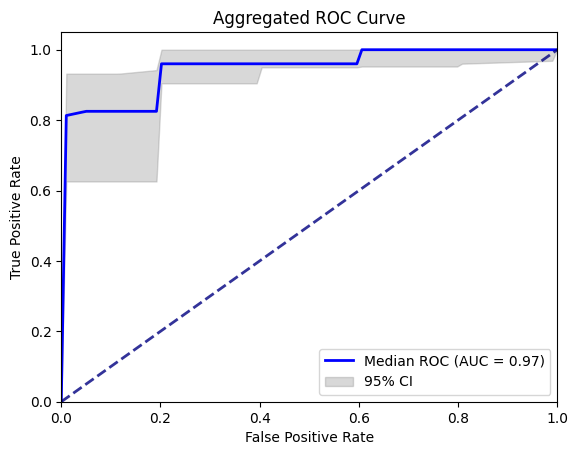

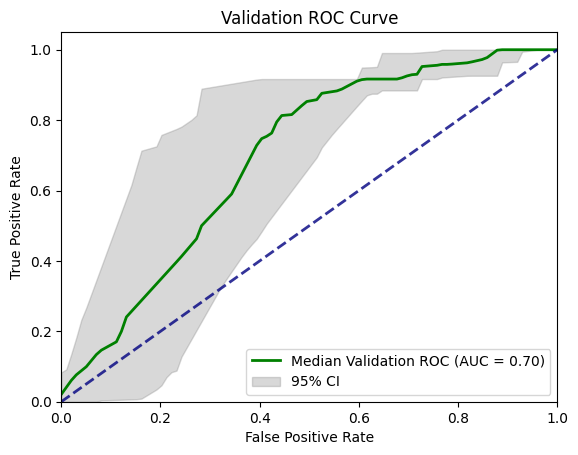

In [30]:
baseline = BaselineClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
baseline.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, n_estimators=50)
baseline.validate_and_plot(d_Mag_prot_shared, cat, 'biochemical control', 'biochemical AD')

# t-test feature selection & LR without refitting

/Users/vincenthbrennsteiner/miniconda3/envs/adaptms/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/vincenthbrennsteiner/miniconda3/envs/adaptms/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/vincenthbrennsteiner/miniconda3/envs/adaptms/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Use

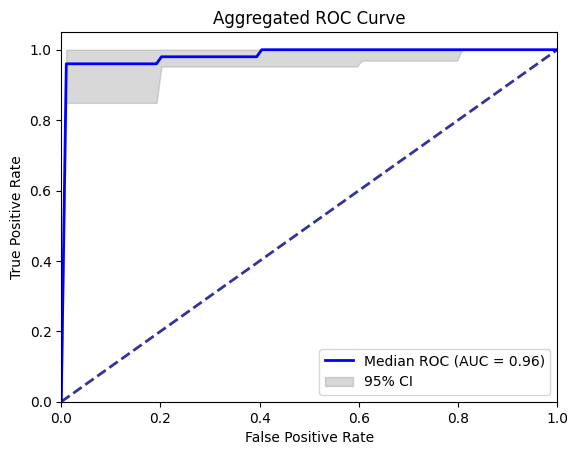

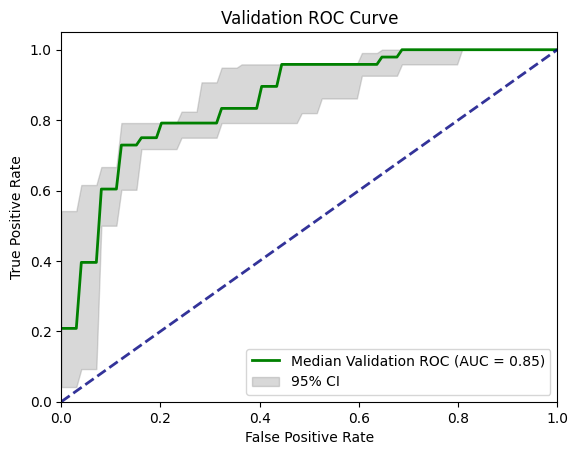

In [31]:
no_refit = NonRefitClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
no_refit.classify_and_plot('biochemical control', 'biochemical AD')
no_refit.validate_and_plot(d_Mag_prot_shared, cat, 'biochemical control', 'biochemical AD')

# ADAPT-MS

In [32]:
cat_MagKiel = cat.copy()
cat_MagKiel.index = [a+'.mzML' for a in cat_MagKiel.index]

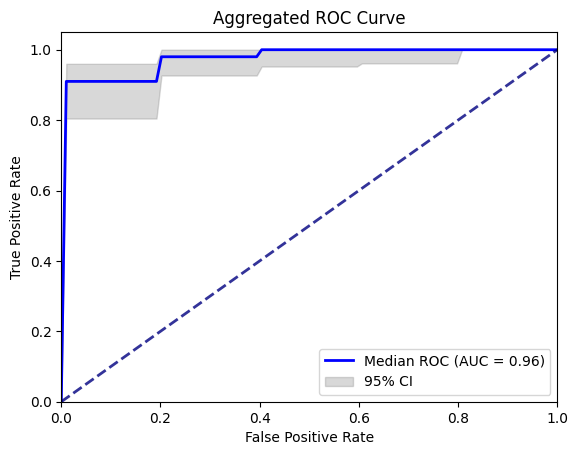

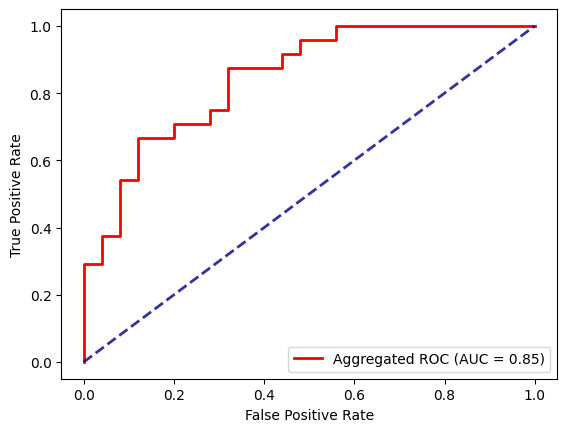

In [33]:
#Initialize the classifier
adaptms = AdaptmsClassifierFolder(prot, cat, gene_dict, between='biochemical AD classification')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms.classify_and_plot('biochemical control', 'biochemical AD')

#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms.classify_directory(file_path / 'Single_file_results/Train_sweden_apply_to_MagKiel', cat_MagKiel, 'biochemical control', 'biochemical AD')
adaptms.plot_accumulated_roc('biochemical control', 'biochemical AD')

# Berlin cohort

In [34]:
# Find shared columns
shared_columns = prot.columns.intersection(d_Berlin_prot.columns)

# Keep only shared columns in both DataFrames
prot_shared = prot[shared_columns]
d_Berlin_prot_shared = d_Berlin_prot[shared_columns]

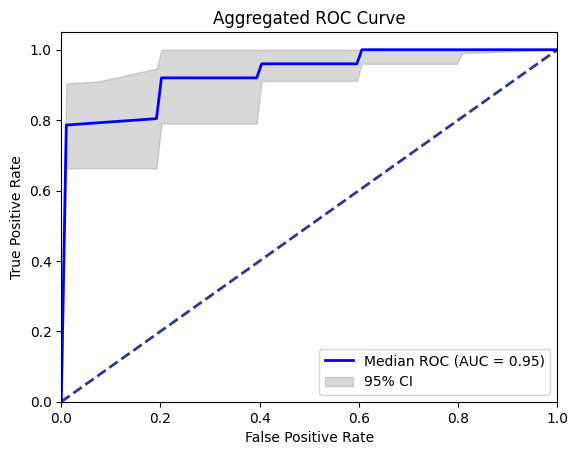

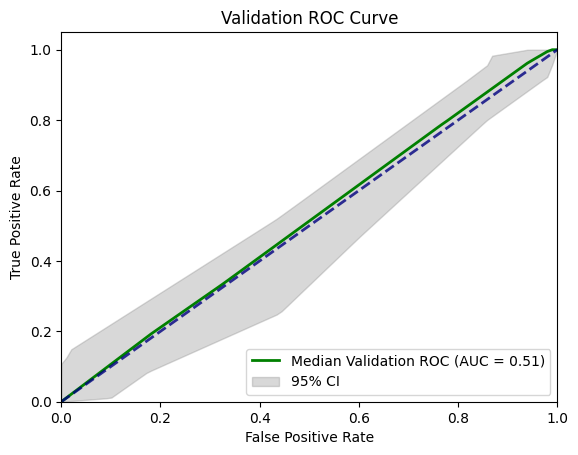

In [35]:
# Initialize the classifier
baseline = BaselineClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
baseline.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, n_estimators=50)
baseline.validate_and_plot(d_Berlin_prot_shared, cat, 'biochemical control', 'biochemical AD')

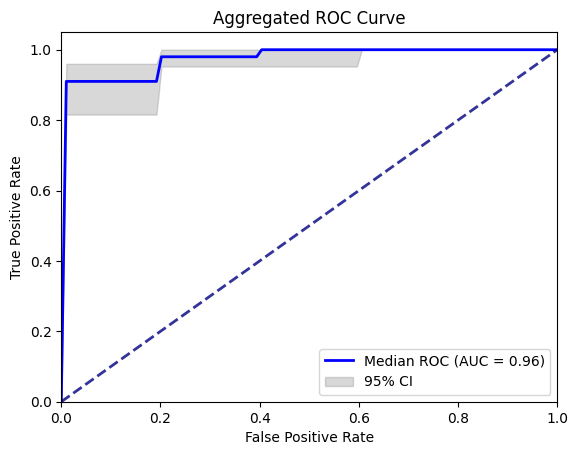

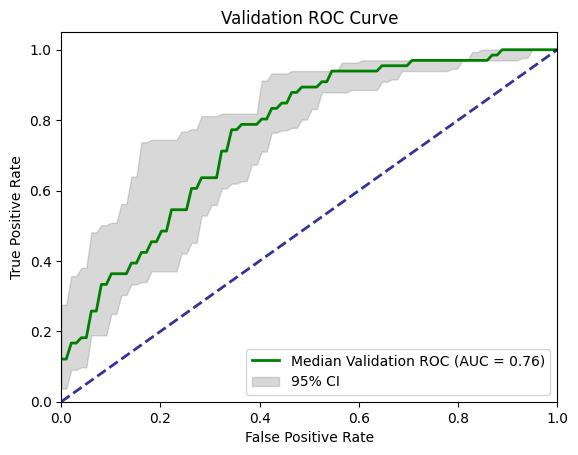

In [36]:
# Initialize the classifier
no_refit = NonRefitClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
no_refit.classify_and_plot('biochemical control', 'biochemical AD')
no_refit.validate_and_plot(d_Berlin_prot_shared, cat, 'biochemical control', 'biochemical AD')

# Berlin ADAPT-MS

In [37]:
cat_Berlin = cat.copy()
cat_Berlin.index = [a+'.mzML' for a in cat_Berlin.index]

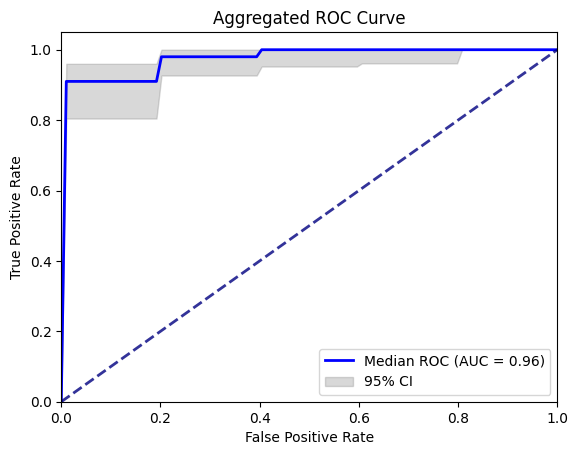

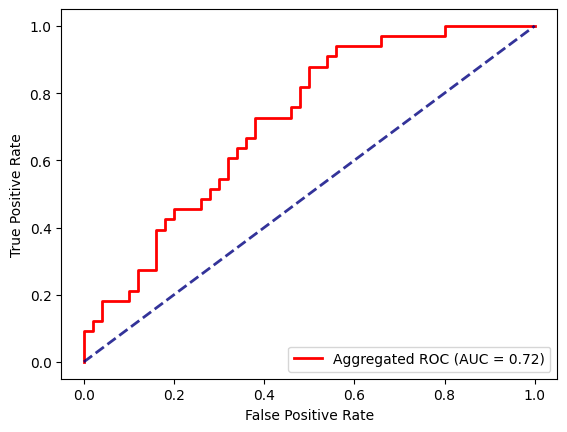

In [38]:
#Initialize the classifier
adaptms = AdaptmsClassifierFolder(prot, cat, gene_dict, between='biochemical AD classification')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, topn_features=50)

#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms.classify_directory(file_path / 'Single_file_results/Train_sweden_apply_to_Berlin', cat_Berlin, 'biochemical control', 'biochemical AD')
adaptms.plot_accumulated_roc('biochemical control', 'biochemical AD')